In [20]:
# %matplotlib inline
# import matplotlib.pyplot as plt
import argparse
import numpy as np
import torch
import cPickle as cp
import sys, os
sys.path.append("../../utils")
sys.path.append("../")

from data_loader import load_census_data
import rff
from rff import GaussianKernel, RFF
from kernel_regressor import Quantizer, KernelRidgeRegression

In [21]:
class Args(object):
    def __init__(self, n_fp_rff, n_bit, 
                 exact_kernel, reg_lambda, 
                 sigma, random_seed, data_path,
                 do_fp, test_var_reduce=False):
        self.n_fp_rff = n_fp_rff
        self.n_bit = n_bit
        self.exact_kernel = exact_kernel
        self.reg_lambda = reg_lambda
        self.sigma = sigma
        self.random_seed = random_seed
        self.data_path = data_path
        self.do_fp = do_fp
        self.test_var_reduce = test_var_reduce

In [22]:
def load_census_data(path):
    X_test = np.load(path + "X_ho.npy")
    X_train = np.load(path + "X_tr.npy")
    Y_test = np.load(path + "Y_ho.npy")
    Y_train = np.load(path + "Y_tr.npy")
    X_test = X_test.item()['X_ho']
    X_train = X_train.item()['X_tr']
    Y_test = Y_test.item()['Y_ho']
    Y_train = Y_train.item()['Y_tr']
#     s = np.arange(X_train.shape[0] )
#     np.random.shuffle(s)
#     X_train = X_train[s, :]
#     Y_train = Y_train[s]
#     X_train, Y_train, X_test, Y_test = \
#       X_train[:(s.size * 2 / 3), :], Y_train[:(s.size * 2 / 3)], X_test[:(s.size * 2 / 3), :], Y_test[:(s.size * 2 / 3)]
    return X_train, X_test, Y_train, Y_test

In [23]:
data_path = "../../../data/census/"

In [24]:
def get_spectrum(args):
    X_train, X_test, Y_train, Y_test = load_census_data(args.data_path)
    kernel = GaussianKernel(sigma=args.sigma)
    kernel_mat_exact_train = kernel.get_kernel_matrix(X_train, X_train)
    kernel_mat_exact_test = kernel.get_kernel_matrix(X_test, X_train)
    n_input_feat = X_train.shape[1]
    assert X_train.shape[1] == X_test.shape[1]
    if args.exact_kernel:
        print "exact kernel"
        kernel = kernel
        quantizer_train = None
        quantizer_test = None
        config_name = "exact_kernel_lambda_" + str(args.reg_lambda) + "_sigma_" + str(args.sigma)
    elif args.do_fp:
        print "full precision rff"
        kernel = RFF(args.n_fp_rff, n_input_feat, kernel, rand_seed=args.random_seed)
        quantizer_train = None
        quantizer_test = None
        config_name = "fp_rff_lambda_" + str(args.reg_lambda) + "_sigma_" \
          + str(args.sigma) + "_n_fp_rff_" + str(args.n_fp_rff)
    else:
        print "low precsion rff with nbit = ", args.n_bit
        n_quantized_rff = int(np.floor(args.n_fp_rff / float(args.n_bit) * 32.0) )
        min_val = -np.sqrt(2.0/float(n_quantized_rff) )
        max_val = np.sqrt(2.0/float(n_quantized_rff) )
        quantizer_train = Quantizer(args.n_bit, min_val, max_val, rand_seed=args.random_seed)
        if not args.test_var_reduce:
            quantizer_test = quantizer_train
        else:
            quantizer_test = None
        kernel = RFF(n_quantized_rff, n_input_feat, kernel, rand_seed=args.random_seed)
        config_name = "lp_rff_lambda_" + str(args.reg_lambda) + "_sigma_" \
          + str(args.sigma) + "_n_fp_rff_" + str(args.n_fp_rff) + "_nbit_" + str(args.n_bit) 

    regressor = KernelRidgeRegression(kernel, reg_lambda=args.reg_lambda)
    print("start to do regression!")
    # print("test quantizer", quantizer)
    regressor.fit(X_train, Y_train, quantizer=quantizer_train)
    print("finish regression!")
    
    kernel_mat = regressor.kernel_mat
    _, s, _ = np.linalg.svd(kernel_mat.cpu().numpy().astype(np.float64), full_matrices=True)
    return s

### exact kernel

In [7]:
args = Args(n_fp_rff=1024, n_bit=8, 
            exact_kernel=True, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_exact = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_exact_64b_svd_full_dataset.npy", "wb") as f:
    np.save(f, s_exact)
# print s_exact

('using sigma ', 30.0)
('using sigma ', 30.0)
exact kernel
start to do regression!
('using sigma ', 30.0)
('using regularior strength ', 0.001)
finish regression!


### 1024 feature full precision

In [8]:
args = Args(n_fp_rff=1024, n_bit=8, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=True)
s_fp = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_1024_feat_fp_64b_svd_full_dataset.npy", "wb") as f:
    np.save(f, s_fp)
# with open("../multi_seed_results/spectrum/s_1024_feat_fp_64b_svd.npy", "rb") as f:
#     test = np.load(f)
# print np.sum(s_fp - test)

('using sigma ', 30.0)
('using sigma ', 30.0)
full precision rff
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 1024)
start to do regression!
('using regularior strength ', 0.001)
finish regression!


### 1024 feature 8 --> 1 bit

In [9]:
args = Args(n_fp_rff=1024, n_bit=8, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_8 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_1024_feat_8_bit_64b_svd_full_dataset.npy", "wb") as f:
    np.save(f, s_8)
# print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  8
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 4096)
start to do regression!
('quantization 1 activated ', (16367, 119))
('quantizer 1 bits', 8)
('quantizer 1 scale', 0.00017331048558493812)
('quantizer using random seed', 1)
('quantization 2 activated ', (16367, 119))
('quantizer 2 bits', 8)
('quantizer 2 scale', 0.00017331048558493812)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!


In [10]:
args = Args(n_fp_rff=1024, n_bit=4, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_4 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_1024_feat_4_bit_64b_svd_full_dataset.npy", "wb") as f:
    np.save(f, s_4)
# print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  4
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 8192)
start to do regression!
('quantization 1 activated ', (16367, 119))
('quantizer 1 bits', 4)
('quantizer 1 scale', 0.0020833333333333333)
('quantizer using random seed', 1)
('quantization 2 activated ', (16367, 119))
('quantizer 2 bits', 4)
('quantizer 2 scale', 0.0020833333333333333)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!


In [11]:
args = Args(n_fp_rff=1024, n_bit=2, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_2 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_1024_feat_2_bit_64b_svd_full_dataset.npy", "wb") as f:
    np.save(f, s_2)
# print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  2
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 16384)
start to do regression!
('quantization 1 activated ', (16367, 119))
('quantizer 1 bits', 2)
('quantizer 1 scale', 0.0073656956373598708)
('quantizer using random seed', 1)
('quantization 2 activated ', (16367, 119))
('quantizer 2 bits', 2)
('quantizer 2 scale', 0.0073656956373598708)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!


In [ ]:
args = Args(n_fp_rff=512, n_bit=1, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_1 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_512_feat_1_bit_64b_svd_full_dataset.npy", "wb") as f:
    np.save(f, s_1)
# print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  1
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 16384)
start to do regression!
('quantization 1 activated ', (16367, 119))
('quantizer 1 bits', 1)
('quantizer 1 scale', 0.022097086912079612)
('quantizer using random seed', 1)
('quantization 2 activated ', (16367, 119))
('quantizer 2 bits', 1)
('quantizer 2 scale', 0.022097086912079612)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!


In [13]:
args = Args(n_fp_rff=1024, n_bit=16, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_16 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_1024_feat_16_bit_64b_svd_full_dataset.npy", "wb") as f:
    np.save(f, s_16)
# print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  16
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 2048)
start to do regression!
('quantization 1 activated ', (16367, 119))
('quantizer 1 bits', 16)
('quantizer 1 scale', 9.5368886854352636e-07)
('quantizer using random seed', 1)
('quantization 2 activated ', (16367, 119))
('quantizer 2 bits', 16)
('quantizer 2 scale', 9.5368886854352636e-07)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!


In [14]:
args = Args(n_fp_rff=1024, n_bit=32, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_32 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_1024_feat_32_bit_64b_svd_full_dataset.npy", "wb") as f:
    np.save(f, s_32)
# print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  32
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 1024)
start to do regression!
('quantization 1 activated ', (16367, 119))
('quantizer 1 bits', 32)
('quantizer 1 scale', 2.0579515879251518e-11)
('quantizer using random seed', 1)
('quantization 2 activated ', (16367, 119))
('quantizer 2 bits', 32)
('quantizer 2 scale', 2.0579515879251518e-11)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!


In [18]:
# with open("../multi_seed_results/spectrum/s_1024_feat_4_bit_64b_svd_full_dataset.npy", "rb") as f:
#     s_4_small = np.load(f)
# with open("../multi_seed_results/spectrum/s_1024_feat_2_bit_64b_svd_full_dataset.npy", "rb") as f:
#     s_2_small = np.load(f)
# with open("../multi_seed_results/spectrum/s_exact_64b_svd_full_dataset.npy", "rb") as f:
#     s_exact_small = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_4_bit_64b_svd_full_dataset.npy", "rb") as f:
    s_4 = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_2_bit_64b_svd_full_dataset.npy", "rb") as f:
    s_2 = np.load(f)
with open("../multi_seed_results/spectrum/s_exact_64b_svd_full_dataset.npy", "rb") as f:
    s_exact = np.load(f)

In [19]:
plt.figure()
plt.semilogy(s_4, label="4 bit full")
plt.semilogy(s_2, label="2 bit full")
plt.semilogy(s_exact, label="exact full")
# plt.semilogy(s_4_small, label="4 bit partial")
# plt.semilogy(s_2_small, label="2 bit partial")
# plt.semilogy(s_exact_small, label="exact partial")
plt.grid()
plt.ylim([1e-13, 1e2])
plt.legend()
plt.show()

IOError: [Errno 13] Permission denied: u'/afs/cs.stanford.edu/u/zjian/.cache/matplotlib/fontList.json'

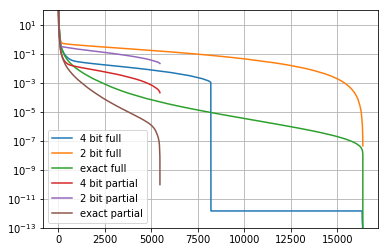

In [14]:
plt.figure()
# plt.semilogy(s_exact, label="exact")
# plt.semilogy(s_fp, label="fp")
# plt.semilogy(s_32, label="32 bit")
# plt.semilogy(s_16, label="16 bit")
# plt.semilogy(s_8, label="8 bit")
plt.semilogy(s_4, label="4 bit full")
plt.semilogy(s_2, label="2 bit full")
plt.semilogy(s_exact, label="exact full")
plt.semilogy(s_4_small, label="4 bit partial")
plt.semilogy(s_2_small, label="2 bit partial")
plt.semilogy(s_exact_small, label="exact partial")
# plt.semilogy(s_1, label="1 bit")
plt.grid()
plt.ylim([1e-13, 1e2])
plt.legend()
plt.show()

### plot full spectrum

In [3]:
with open("../multi_seed_results/spectrum/s_1024_feat_32_bit_64b_svd.npy", "rb") as f:
    s_32 = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_16_bit_64b_svd.npy", "rb") as f:
    s_16 = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_8_bit_64b_svd.npy", "rb") as f:
    s_8 = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_4_bit_64b_svd.npy", "rb") as f:
    s_4 = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_2_bit_64b_svd.npy", "rb") as f:
    s_2 = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_1_bit_64b_svd.npy", "rb") as f:
    s_1 = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_fp_64b_svd.npy", "rb") as f:
    s_fp = np.load(f)
with open("../multi_seed_results/spectrum/s_exact.npy", "rb") as f:
    s_exact = np.load(f)

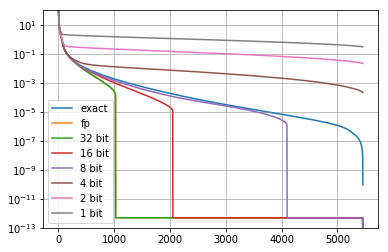

In [4]:
plt.figure()
plt.semilogy(s_exact, label="exact")
plt.semilogy(s_fp, label="fp")
plt.semilogy(s_32, label="32 bit")
plt.semilogy(s_16, label="16 bit")
plt.semilogy(s_8, label="8 bit")
plt.semilogy(s_4, label="4 bit")
plt.semilogy(s_2, label="2 bit")
plt.semilogy(s_1, label="1 bit")
plt.grid()
plt.ylim([1e-13, 1e2])
plt.legend()
plt.show()

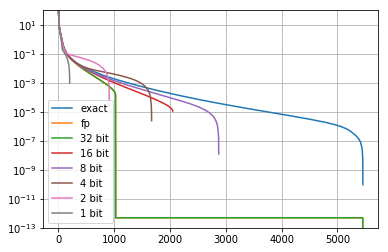

In [5]:
plt.figure()
plt.semilogy(s_exact, label="exact")
plt.semilogy(s_fp, label="fp")
plt.semilogy(s_32 - 2.0 * (1/ float(2**32 - 1) )**2, label="32 bit")
plt.semilogy(s_16 - 2.0 * (1/ float(2**16 - 1) )**2, label="16 bit")
plt.semilogy(s_8 - 2.0 * (1/ float(2**8 - 1) )**2, label="8 bit")
plt.semilogy(s_4 - 2.0 * (1/ float(2**4 - 1) )**2, label="4 bit")
plt.semilogy(s_2 - 2.0 * (1/ float(2**2 - 1) )**2, label="2 bit")
plt.semilogy(s_1 - 2.0 * (1/ float(2**1 - 1) )**2, label="1 bit")
plt.grid()
plt.ylim([1e-13, 1e2])
plt.legend()
plt.show()

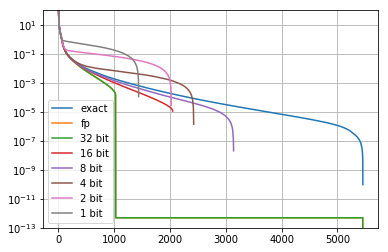

In [6]:
plt.figure()
plt.semilogy(s_exact, label="exact")
plt.semilogy(s_fp, label="fp")
plt.semilogy(s_32 - 2.0 / 3.0 * 2.0 * (1/ float(2**32 - 1) )**2, label="32 bit")
plt.semilogy(s_16 - 2.0 / 3.0 * 2.0 * (1/ float(2**16 - 1) )**2, label="16 bit")
plt.semilogy(s_8 - 2.0 / 3.0 * 2.0 * (1/ float(2**8 - 1) )**2, label="8 bit")
plt.semilogy(s_4 - 2.0 / 3.0 * 2.0 * (1/ float(2**4 - 1) )**2, label="4 bit")
plt.semilogy(s_2 - 2.0 / 3.0 * 2.0 * (1/ float(2**2 - 1) )**2, label="2 bit")
plt.semilogy(s_1 - 2.0 / 3.0 * 2.0 * (1/ float(2**1 - 1) )**2, label="1 bit")
plt.grid()
plt.ylim([1e-13, 1e2])
plt.legend()
plt.show()

### exploration on spectrum

In [37]:
def get_spectrum_test(args):
    X_train, X_test, Y_train, Y_test = load_census_data(args.data_path)
    kernel = GaussianKernel(sigma=args.sigma)
    kernel_mat_exact_train = kernel.get_kernel_matrix(X_train, X_train)
    kernel_mat_exact_test = kernel.get_kernel_matrix(X_test, X_train)
    n_input_feat = X_train.shape[1]
    assert X_train.shape[1] == X_test.shape[1]
    if args.exact_kernel:
        print "exact kernel"
        kernel = kernel
        quantizer_train = None
        quantizer_test = None
        config_name = "exact_kernel_lambda_" + str(args.reg_lambda) + "_sigma_" + str(args.sigma)
    elif args.do_fp:
        print "full precision rff"
        kernel = RFF(args.n_fp_rff, n_input_feat, kernel, rand_seed=args.random_seed)
        quantizer_train = None
        quantizer_test = None
        config_name = "fp_rff_lambda_" + str(args.reg_lambda) + "_sigma_" \
          + str(args.sigma) + "_n_fp_rff_" + str(args.n_fp_rff)
    else:
        print "low precsion rff with nbit = ", args.n_bit
        n_quantized_rff = int(np.floor(args.n_fp_rff / float(args.n_bit) * 32.0) )
        min_val = -np.sqrt(2.0/float(n_quantized_rff) )
        max_val = np.sqrt(2.0/float(n_quantized_rff) )
        quantizer_train = Quantizer(args.n_bit, min_val, max_val, rand_seed=args.random_seed)
        if not args.test_var_reduce:
            quantizer_test = quantizer_train
        else:
            quantizer_test = None
        kernel = RFF(n_quantized_rff, n_input_feat, kernel, rand_seed=args.random_seed)
        config_name = "lp_rff_lambda_" + str(args.reg_lambda) + "_sigma_" \
          + str(args.sigma) + "_n_fp_rff_" + str(args.n_fp_rff) + "_nbit_" + str(args.n_bit) 

    regressor = KernelRidgeRegression(kernel, reg_lambda=args.reg_lambda)
    print("start to do regression!")
    # print("test quantizer", quantizer)
    regressor.fit(X_train, Y_train, quantizer=quantizer_train)
    print("finish regression!")
    
    print "test rff1 ", regressor.kernel.rff_x1
    print "test rff2 ", regressor.kernel.rff_x2
    
    
    kernel_mat = regressor.kernel_mat
    _, s, _ = np.linalg.svd(kernel_mat.cpu().numpy().astype(np.float64), full_matrices=True)
    return s, kernel_mat.cpu().numpy().astype(np.float64)

In [38]:
args = Args(n_fp_rff=1024, n_bit=1, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_1_test, kernel_1_test = get_spectrum_test(args)

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  1
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 32768)
start to do regression!


KeyboardInterrupt: 

[ 2.  2.  2. ...,  2.  2.  2.]
[[ 2.          0.92578125  0.8515625  ...,  0.84863281  0.84277344
   0.91308594]
 [ 0.92578125  2.          0.94335938 ...,  0.88378906  0.87011719
   0.93457031]
 [ 0.8515625   0.94335938  2.         ...,  0.86230469  0.87597656
   0.91894531]]


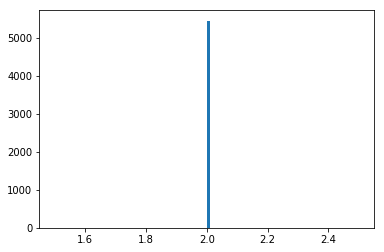

In [39]:
print np.diag(kernel_1_test)
print kernel_1_test[0:3,:]
plt.figure()
_ = plt.hist(np.diag(kernel_1_test),bins=100)
plt.show()

In [42]:
args = Args(n_fp_rff=1024, n_bit=2, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_1_test, kernel_1_test = get_spectrum_test(args)

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  2
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 16384)
start to do regression!
('quantization 1 activated ', (5456, 119))
('quantizer 1 bits', 2)
('quantizer 1 scale', 0.0073656956373598708)
('quantizer using random seed', 1)
('quantization 2 activated ', (5456, 119))
('quantizer 2 bits', 2)
('quantizer 2 scale', 0.0073656956373598708)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!
test rff1  
1.00000e-02 *
-1.1049  0.3683  0.3683  ...  -0.3683  0.3683  1.1049
-1.1049 -0.3683  1.1049  ...  -1.1049  1.1049  0.3683
-0.3683 -1.1049  1.1049  ...  -0.3683  1.1049  1.1049
          ...             ⋱             ...          
-1.1049 -0.3683  1.1049  ...  -1.1049  0.3683  1.1049
-1.1049 -0.3683  1.1049  ...  -1.1049  1.1049  1.1049
-0.3683 -1.1049  1.1049  ...  -0.3683  1.1049  0.3683
[torch.DoubleTensor of size 5456x16384]

test rff

[ 1.09895833  1.12087674  1.12717014 ...,  1.1265191   1.12836372
  1.12250434]
[[ 1.09895833  0.84337023  0.8390842  ...,  0.85161675  0.7464464
   0.83037652]
 [ 0.84337023  1.12087674  0.95876736 ...,  0.94986979  0.92938911
   0.91414388]
 [ 0.8390842   0.95876736  1.12717014 ...,  0.9570855   0.90725369
   0.9121365 ]]


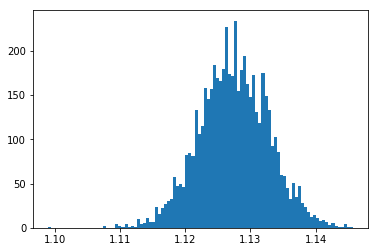

In [43]:
print np.diag(kernel_1_test)
print kernel_1_test[0:3,:]
plt.figure()
_ = plt.hist(np.diag(kernel_1_test),bins=100)
plt.show()

[  4.87422412e+03   9.92007523e+01   7.62955627e+01 ...,   6.18245899e-09
   4.54027393e-09   9.55269891e-11]


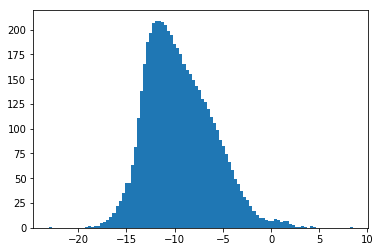

In [6]:
print s_exact
plt.figure()
_ = plt.hist(np.log(s_exact),bins=100)
plt.show()

[  4.91588923e+03   9.76161314e+01   7.45011299e+01 ...,   4.80692726e-13
   1.01362488e-13   4.13374761e-14]


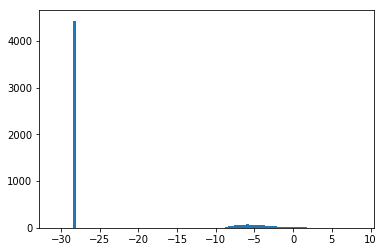

In [7]:
print s_fp
plt.figure()
_ = plt.hist(np.log(s_fp),bins=100)
plt.show()

[  4.91645370e+03   9.36678968e+01   7.49424546e+01 ...,   4.90781849e-13
   1.30537380e-13   3.44960307e-14]


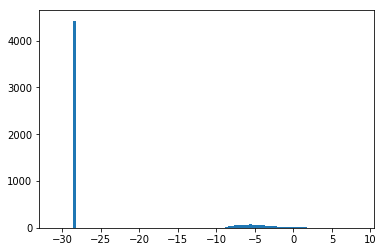

In [8]:
print s_32
plt.figure()
_ = plt.hist(np.log(s_32),bins=100)
plt.show()

[  4.92772646e+03   9.92845382e+01   7.16227742e+01 ...,   1.30972131e-13
   5.50731281e-14   5.32621153e-14]


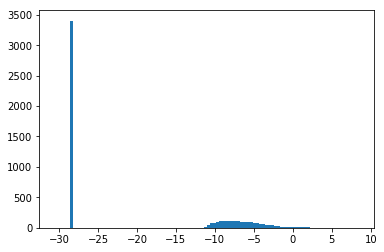

In [9]:
print s_16
plt.figure()
_ = plt.hist(np.log(s_16),bins=100)
plt.show()

[  4.79986673e+03   1.01274638e+02   8.09237702e+01 ...,   2.91166374e-14
   2.01892143e-14   6.35161380e-15]


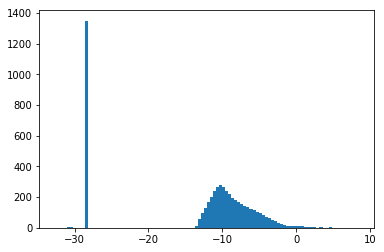

In [10]:
print s_8
plt.figure()
_ = plt.hist(np.log(s_8),bins=100)
plt.show()

[  4.85706958e+03   1.03042343e+02   7.59865365e+01 ...,   2.20834156e-04
   2.13297390e-04   2.10150551e-04]


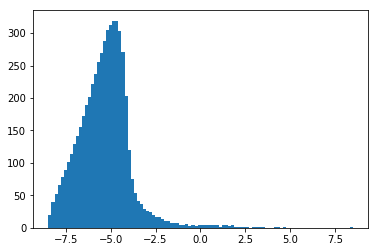

In [11]:
print s_4
plt.figure()
_ = plt.hist(np.log(s_4),bins=100)
plt.show()

[  4.87785233e+03   1.00451189e+02   8.06809640e+01 ...,   2.18074883e-02
   2.16997374e-02   2.16595938e-02]


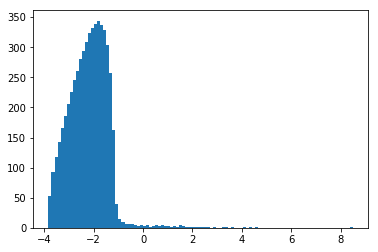

In [12]:
print s_2
plt.figure()
_ = plt.hist(np.log(s_2),bins=100)
plt.show()

[  4.87050873e+03   9.96647985e+01   8.00128565e+01 ...,   3.02800135e-01
   3.01387460e-01   3.00918557e-01]


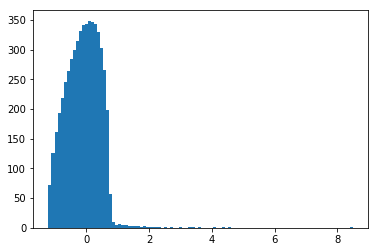

In [13]:
print s_1
plt.figure()
_ = plt.hist(np.log(s_1),bins=100)
plt.show()

# Below are old cold

(array([ 18.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  7.01975496e-03,   1.65006816e+00,   3.29311657e+00,
          4.93616497e+00,   6.57921338e+00,   8.22226178e+00,
          9.86531019e+00,   1.15083586e+01,   1.31514070e+01,
          1.47944554e+01,   1.64375038e+01]),
 <a list of 10 Patch objects>)

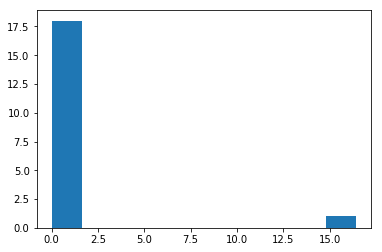

In [56]:
plt.hist(s)